# **Struktur Proyek Maggot Classify**

1. Pendahuluan
2. Data Wrangling
  * Pengumpulan Data (Gathering Data)
  * Penilaian Data (Assessing Data)
  * Pembersihan Data (Cleaning Data)
3. Exploratory Data Analysis (EDA)
4. Visualisasi Data
5. Pengembangan Dashboard dengan Streamlit
6. Deployment
7. Kesimpulan

# BSF Larvae Classification & Object Detection

##1.Pendahuluan

### Tujuan Proyek
Mengembangkan model Machine Learning berbasis TensorFlow untuk mengklasifikasikan tahap pertumbuhan larva BSF menjadi enam kategori.

### Masalah yang Diselesaikan
- Kurangnya akses bagi peternak maggot di daerah terpencil.
- Membantu peternak mengenali tahapan larva untuk meningkatkan efisiensi produksi.

### Pendekatan
Dataset diambil dari Roboflow dan melalui preprocessing serta augmentasi untuk menghasilkan model yang robust. Model akan dioptimalkan untuk TensorFlow Lite agar dapat digunakan di aplikasi mobile.


##2 Data Wrangling

### **2.1 Pengumpulan Data (Data Gathering)**

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="XO92AkNJ7hQPqZW5Jg6d")
# project = rf.workspace("maggot").project("larva-13aob-ultfr")
# version = project.version(1)
# dataset = version.download("tfrecord")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to larva-1 in tfrecord:: 100%|██████████| 11/11 [00:00<00:00, 11.45it/s]


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!ls -lh "/content/drive/MyDrive/Maggotclassify"


total 18K
-rw------- 1 root root  133 Nov 23 18:34 README.dataset.txt
-rw------- 1 root root  910 Nov 23 18:34 README.roboflow.txt
drwx------ 2 root root 4.0K Nov 23 18:34 test
drwx------ 2 root root 4.0K Nov 23 19:44 test_image
drwx------ 2 root root 4.0K Nov 23 18:34 train
drwx------ 2 root root 4.0K Nov 23 18:34 valid


In [4]:
import os
data_dir = "/content/drive/MyDrive/Maggotclassify"
files = os.listdir(data_dir)
print("Files in dataset directory:", files)

Files in dataset directory: ['train', 'test', 'README.roboflow.txt', 'README.dataset.txt', 'valid', 'test_image']


In [5]:
import tensorflow as tf

# Path ke masing-masing dataset
train_tfrecord = "/content/drive/My Drive/Maggotclassify/train/larva.tfrecord"
valid_tfrecord = "/content/drive/My Drive/Maggotclassify/valid/larva.tfrecord"
test_tfrecord = "/content/drive/My Drive/Maggotclassify/test/larva.tfrecord"
label_map_path = "/content/drive/My Drive/Maggotclassify/train/larva_label_map.pbtxt"

# Fungsi parsing
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(example, feature_description)

# Memuat dataset training
raw_train_dataset = tf.data.TFRecordDataset(train_tfrecord)
parsed_train_dataset = raw_train_dataset.map(parse_tfrecord_fn)

# Memuat dataset validasi
raw_valid_dataset = tf.data.TFRecordDataset(valid_tfrecord)
parsed_valid_dataset = raw_valid_dataset.map(parse_tfrecord_fn)

# Memuat dataset testing
raw_test_dataset = tf.data.TFRecordDataset(test_tfrecord)
parsed_test_dataset = raw_test_dataset.map(parse_tfrecord_fn)


In [6]:
!find "/content/drive/My Drive/Maggotclassify" -type f


/content/drive/My Drive/Maggotclassify/train/larva_label_map.pbtxt
/content/drive/My Drive/Maggotclassify/train/larva.tfrecord
/content/drive/My Drive/Maggotclassify/test/larva_label_map.pbtxt
/content/drive/My Drive/Maggotclassify/test/larva.tfrecord
/content/drive/My Drive/Maggotclassify/README.roboflow.txt
/content/drive/My Drive/Maggotclassify/README.dataset.txt
/content/drive/My Drive/Maggotclassify/valid/larva.tfrecord
/content/drive/My Drive/Maggotclassify/valid/larva_label_map.pbtxt
/content/drive/My Drive/Maggotclassify/test_image/maggots.jpeg
/content/drive/My Drive/Maggotclassify/test_image/prepupa maggot.jpeg
/content/drive/My Drive/Maggotclassify/test_image/maggot tahap 3.jpeg
/content/drive/My Drive/Maggotclassify/test_image/maggot kecil.jpeg
/content/drive/My Drive/Maggotclassify/test_image/maggot putih.png
/content/drive/My Drive/Maggotclassify/test_image/maggot 1.png


Image size: 640x640


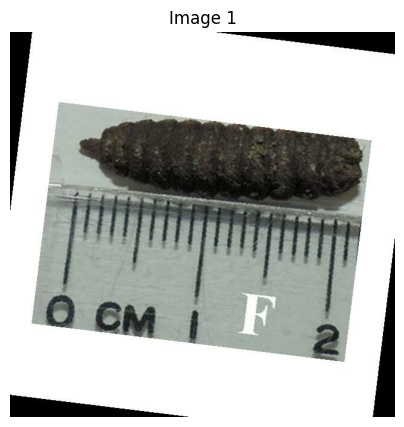

Image size: 640x640


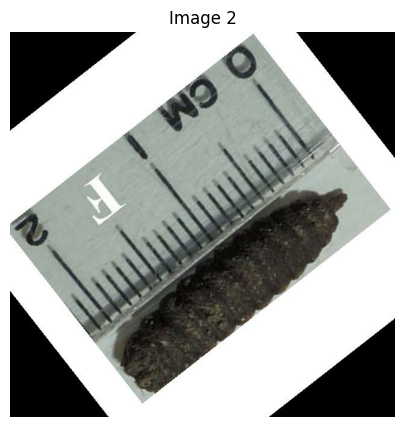

Image size: 480x640


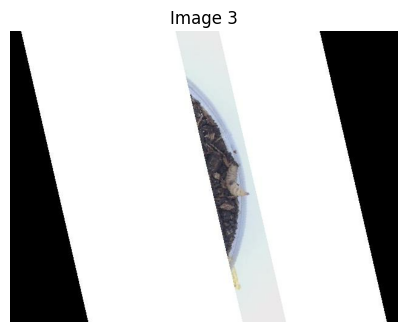

Image size: 480x640


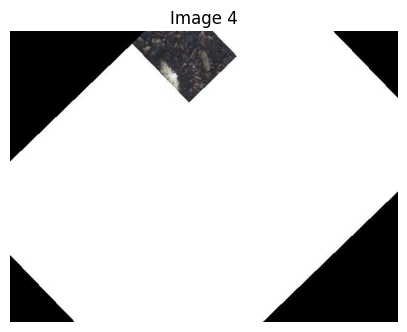

Image size: 480x640


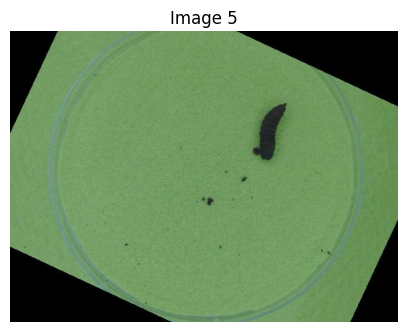

In [7]:
import matplotlib.pyplot as plt

def decode_image(example):
    image = tf.io.decode_jpeg(example['image/encoded'], channels=3)
    height = example['image/height'].numpy()
    width = example['image/width'].numpy()
    return image, height, width

# Menampilkan beberapa gambar dari training dataset
for i, example in enumerate(parsed_train_dataset.take(5)):  # Ambil 5 sampel pertama
    image, height, width = decode_image(example)
    print(f"Image size: {height}x{width}")
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    plt.axis('off')
    plt.show()


# Train Bounding Box

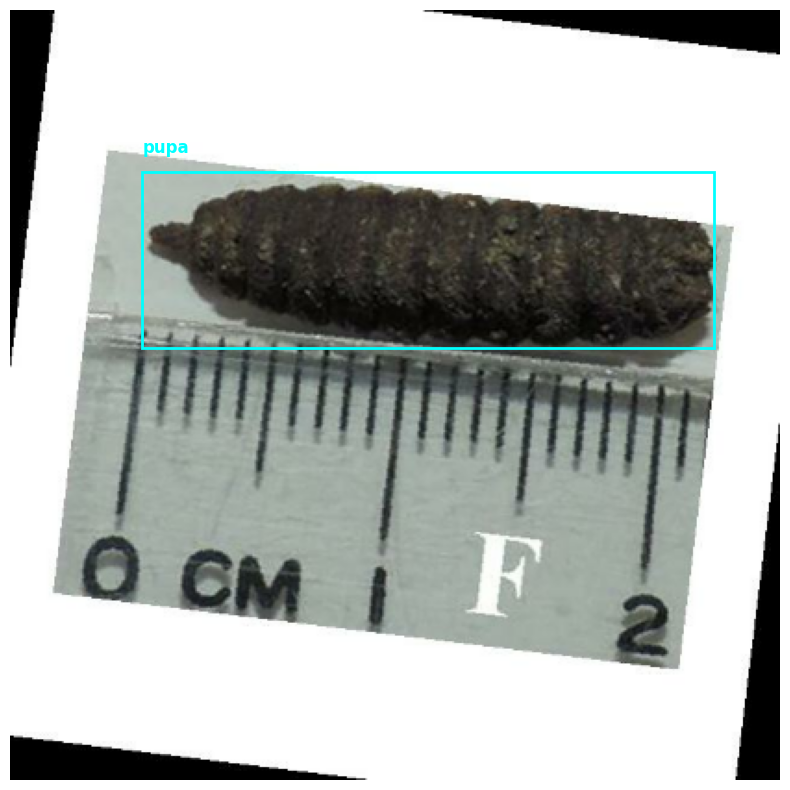

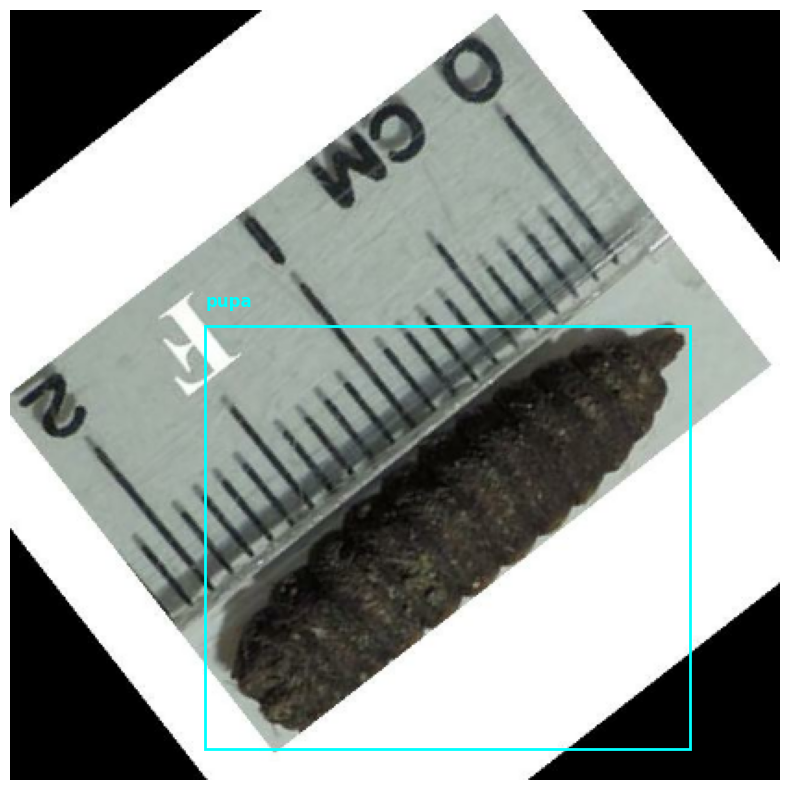

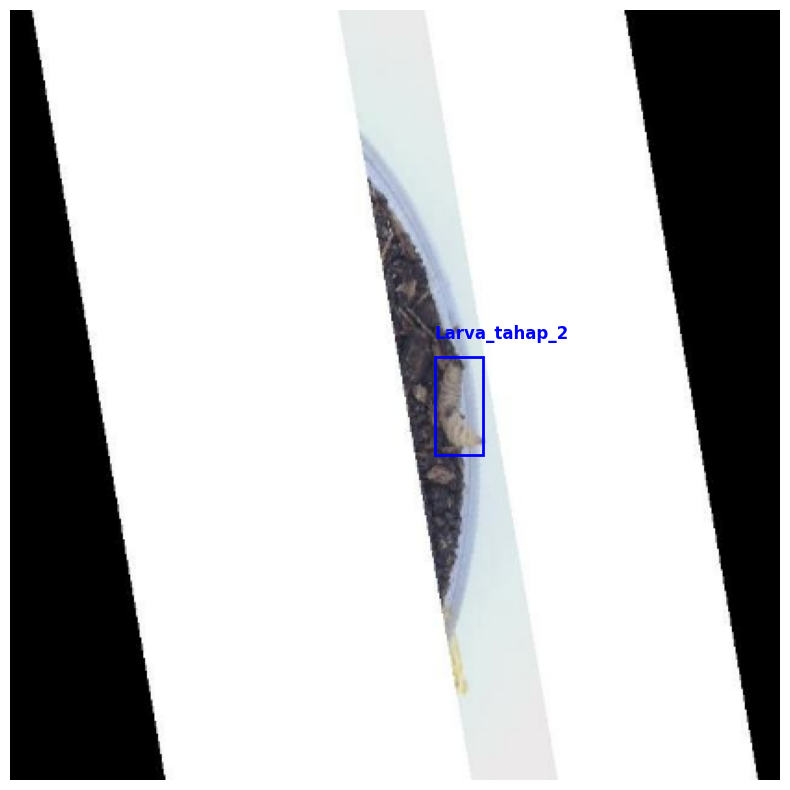

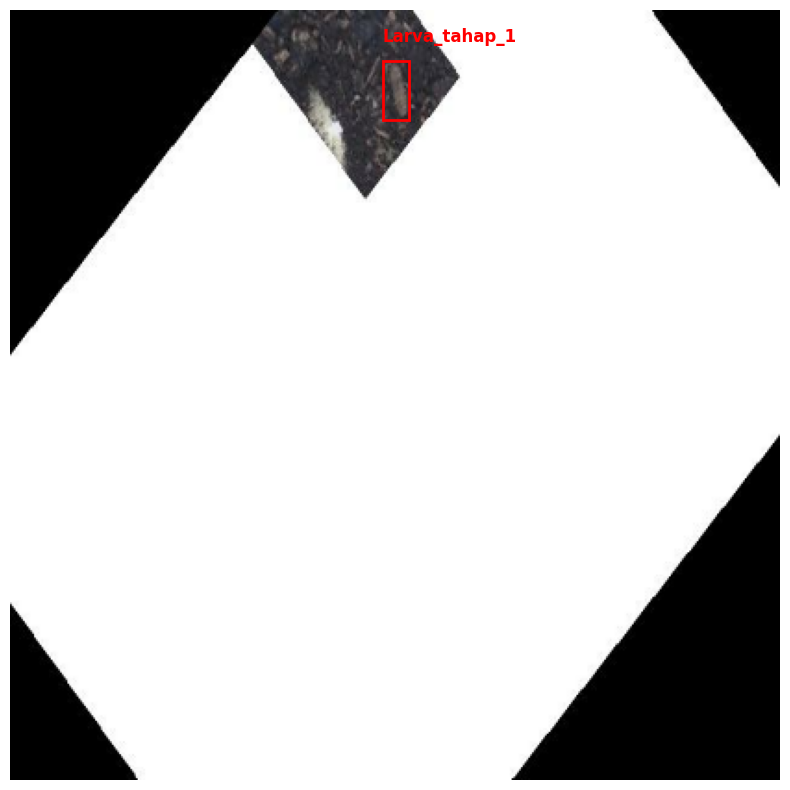

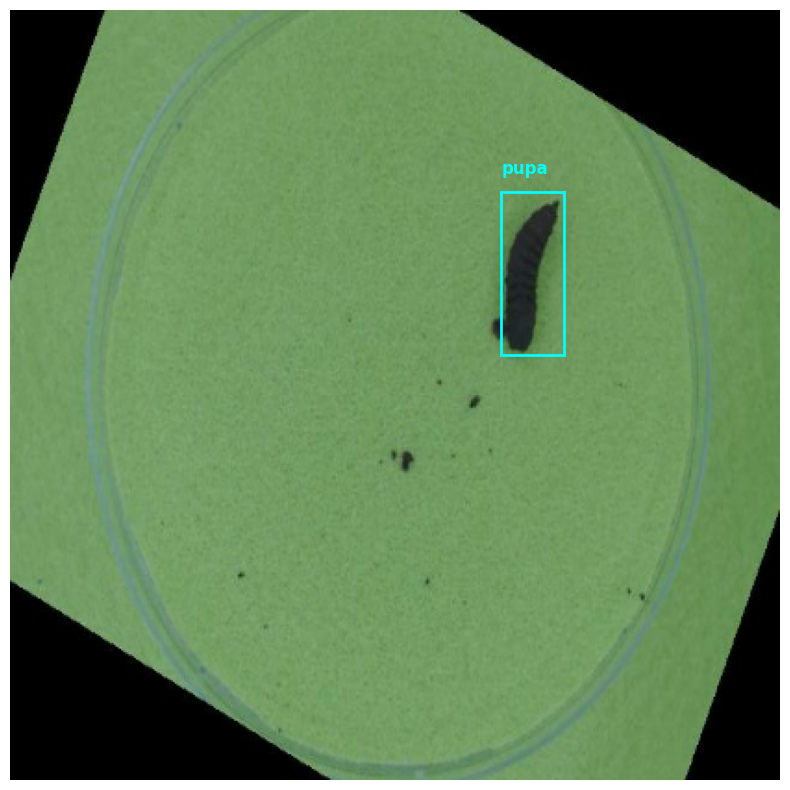

In [ ]:
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# # Parsing TFRecord dengan bounding box
# def parse_tfrecord_with_bbox(example):
#     feature_description = {
#         'image/encoded': tf.io.FixedLenFeature([], tf.string),
#         'image/height': tf.io.FixedLenFeature([], tf.int64),
#         'image/width': tf.io.FixedLenFeature([], tf.int64),
#         'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
#         'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
#         'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
#         'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
#         'image/object/class/label': tf.io.VarLenFeature(tf.int64),
#     }
#     parsed_example = tf.io.parse_single_example(example, feature_description)

#     # Decode image
#     image = tf.io.decode_jpeg(parsed_example['image/encoded'], channels=3)
#     image = tf.image.resize(image, [416, 416])  # Resize ke ukuran konsisten

#     # Extract bounding boxes and labels
#     bboxes = {
#         "xmin": tf.sparse.to_dense(parsed_example['image/object/bbox/xmin']),
#         "xmax": tf.sparse.to_dense(parsed_example['image/object/bbox/xmax']),
#         "ymin": tf.sparse.to_dense(parsed_example['image/object/bbox/ymin']),
#         "ymax": tf.sparse.to_dense(parsed_example['image/object/bbox/ymax']),
#     }
#     labels = tf.sparse.to_dense(parsed_example['image/object/class/label'])

#     return image, bboxes, labels

# # Load dataset
# def load_dataset_with_bbox(tfrecord_path):
#     raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
#     return raw_dataset.map(parse_tfrecord_with_bbox)

# # Visualisasi gambar dengan bounding box
# def visualize_image_with_bbox(image, bboxes, labels, label_map):
#     fig, ax = plt.subplots(1, figsize=(10, 10))

#     # Tampilkan gambar
#     ax.imshow(image.numpy().astype("uint8"))

#     # Warna untuk tiap kelas
#     class_colors = {
#         1: 'red', 2: 'blue', 3: 'green',
#         4: 'orange', 5: 'purple', 6: 'cyan'
#     }

#     # Gambarkan bounding box
#     height, width, _ = image.shape
#     for i in range(len(labels)):
#         xmin = int(bboxes["xmin"][i] * width)
#         xmax = int(bboxes["xmax"][i] * width)
#         ymin = int(bboxes["ymin"][i] * height)
#         ymax = int(bboxes["ymax"][i] * height)
#         label = labels[i].numpy()

#         # Bounding box
#         rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
#                                  linewidth=2, edgecolor=class_colors[label], facecolor='none')
#         ax.add_patch(rect)

#         # Label teks
#         ax.text(xmin, ymin - 10, label_map[label], color=class_colors[label], fontsize=12, weight='bold')

#     plt.axis('off')
#     plt.show()

# # Label map
# label_map = {
#     1: "Larva_tahap_1",
#     2: "Larva_tahap_2",
#     3: "Larvatahap_3",
#     4: "Maggot",
#     5: "Pra-pupa",
#     6: "pupa"
# }

# # Uji visualisasi
# tfrecord_path = "/content/drive/My Drive/Maggotclassify/train/larva.tfrecord"
# dataset = load_dataset_with_bbox(tfrecord_path)

# # Tampilkan 5 gambar pertama dengan bounding box
# for image, bboxes, labels in dataset.take(5):
#     visualize_image_with_bbox(image, bboxes, labels, label_map)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

# Parsing dataset
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image/encoded'], channels=3)
    image = tf.image.resize(image, [128, 128])  # Ubah ukuran ke 128x128
    label = tf.sparse.to_dense(example['image/object/class/label'])
    return image, tf.reduce_max(label)  # Ambil satu label per gambar

# Load dataset
def load_dataset(tfrecord_path, batch_size=16):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    parsed_dataset = raw_dataset.map(parse_tfrecord_fn)
    return parsed_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_data = load_dataset(train_tfrecord)
valid_data = load_dataset(valid_tfrecord)

# Model sederhana untuk percobaan
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')  # Enam kelas diubah menjadi tujuh
])

model.summary()

# Kompilasi model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks untuk menyimpan model
checkpoint = ModelCheckpoint("model_small_checkpoint.keras", save_best_only=True, monitor="val_accuracy", mode="max")

# Latih model
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=5,  # Kurangi jumlah epoch untuk pengujian cepat
    callbacks=[checkpoint]
)

# Evaluasi awal
test_data = load_dataset(test_tfrecord)
results = model.evaluate(test_data)
print(f"Test Accuracy: {results[1]}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       1,843,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,848,807 (7.05 MB)

 Trainable params: 1,848,807 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 112s 262ms/step - accuracy: 0.2805 - loss: 65.1412 - val_accuracy: 0.6288 - val_loss: 0.9336
Epoch 2/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 140s 257ms/step - accuracy: 0.7784 - loss: 0.6026 - val_accuracy: 0.8664 - val_loss: 0.4143
Epoch 3/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 142s 257ms/step - accuracy: 0.9316 - loss: 0.2318 - val_accuracy: 0.9198 - val_loss: 0.2355
Epoch 4/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 142s 258ms/step - accuracy: 0.9748 - loss: 0.0902 - val_accuracy: 0.9332 - val_loss: 0.4595
Epoch 5/5
421/421 ━━━━━━━━━━━━━━━━━━━━ 143s 261ms/step - accuracy: 0.9608 - loss: 0.1556 - val_accuracy: 0.9785 - val_loss: 0.0649
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9879 - loss: 0.0456
Test Accuracy: 0.9905660152435303


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━

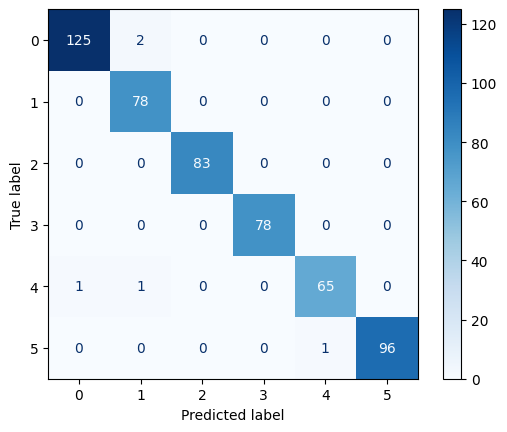

In [10]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ambil prediksi
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(6))
disp.plot(cmap="Blues")
plt.show()


In [11]:
import tensorflow as tf

# Path ke label map
label_map_path = "/content/drive/My Drive/Maggotclassify/train/larva_label_map.pbtxt"

# Fungsi untuk membaca label map
def read_label_map(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    labels = {}
    for i in range(0, len(lines), 5):
        # The following line is modified to handle commas or other non-digit characters
        label_id = int(lines[i+2].split('id: ')[1].strip().split(',')[0])  # Split by comma and take the first part
        label_name = lines[i+3].split('name: "')[1].split('"')[0].strip()
        labels[label_id] = label_name
    return labels

# Membaca label map
labels = read_label_map(label_map_path)

# Menampilkan nama label
for label_id, label_name in labels.items():
    print(f"Label ID: {label_id}, Label Name: {label_name}")

Label ID: 1, Label Name: larva_tahap_1
Label ID: 2, Label Name: larva_tahap_2
Label ID: 3, Label Name: larva_tahap_3
Label ID: 4, Label Name: maggot
Label ID: 5, Label Name: prapupa
Label ID: 6, Label Name: pupa


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


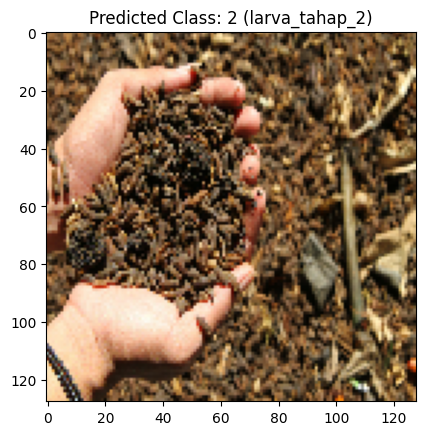

In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Path ke label map
label_map_path = "/content/drive/My Drive/Maggotclassify/train/larva_label_map.pbtxt"

# Fungsi untuk membaca label map (sama seperti sebelumnya)
def read_label_map(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    labels = {}
    for i in range(0, len(lines), 5):
        label_id = int(lines[i+2].split('id: ')[1].strip().split(',')[0])
        label_name = lines[i+3].split('name: "')[1].split('"')[0].strip()
        labels[label_id] = label_name
    return labels

# Membaca label map
labels = read_label_map(label_map_path)

def test_single_image(model, image_path, labels):
    # Load gambar
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = tf.expand_dims(img, 0) / 255.0  # Normalisasi

    # Prediksi
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)

    # Dapatkan nama label
    predicted_label = labels[predicted_class]  # Menggunakan dict labels

    # Tampilkan gambar dan nama label
    plt.imshow(img[0])
    plt.title(f"Predicted Class: {predicted_class} ({predicted_label})")
    plt.show()

# Uji gambar
test_single_image(model, "/content/drive/MyDrive/Maggotclassify/test_image/maggots.jpeg", labels)

In [15]:
# prompt: tampilkan count class dalam data train

import tensorflow as tf

# Path ke masing-masing dataset
train_tfrecord = "/content/drive/My Drive/Maggotclassify/train/larva.tfrecord"

# Parsing dataset untuk menghitung jumlah kelas
def count_classes(tfrecord_path):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    class_counts = {}
    for raw_record in raw_dataset:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        for feature in example.features.feature:
          if feature == 'image/object/class/label':
            labels = example.features.feature[feature].int64_list.value
            for label in labels:
              class_counts[label] = class_counts.get(label,0)+1

    return class_counts

# Hitung jumlah kelas pada dataset training
class_counts = count_classes(train_tfrecord)

# Tampilkan hasil
print("Jumlah kelas dalam data train:")
for class_id, count in class_counts.items():
  print(f"Class {class_id}: {count}")

Jumlah kelas dalam data train:
Class 6: 1432
Class 2: 1714
Class 1: 1411
Class 5: 1603
Class 3: 1772
Class 4: 1810


In [16]:
# prompt: total keseluruhan data train

# Path ke masing-masing dataset
train_tfrecord = "/content/drive/My Drive/Maggotclassify/train/larva.tfrecord"

# Fungsi untuk menghitung total data dalam TFRecord
def count_total_data(tfrecord_path):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    total_data = 0
    for _ in raw_dataset:
        total_data += 1
    return total_data

# Hitung total data training
total_train_data = count_total_data(train_tfrecord)

# Tampilkan hasilnya
print(f"Total data dalam dataset training: {total_train_data}")

Total data dalam dataset training: 6729


In [ ]:
# care_recommendations = {
#     1: {
#         "stage": "Larva Awal",
#         "feed": "Beri pakan berupa bahan organik lunak seperti sisa buah atau sayur.",
#         "temperature": "25-30°C",
#         "humidity": "70-80%",
#         "note": "Pada tahap ini, larva masih kecil dan baru mulai tumbuh. Lingkungan yang lembap sangat penting untuk mendukung pertumbuhan awal.",
#         "education": "Tahap ini sangat penting untuk menentukan kualitas larva. Anda dapat memanfaatkan limbah rumah tangga organik untuk mengurangi sampah sekaligus menghasilkan larva berkualitas tinggi."
#     },
#     2: {
#         "stage": "Larva Pertengahan",
#         "feed": "Tambahkan bahan organik padat seperti limbah sayuran dan buah-buahan yang lebih keras.",
#         "temperature": "30-35°C",
#         "humidity": "60-70%",
#         "note": "Larva mulai tumbuh lebih cepat dan membutuhkan lebih banyak nutrisi.",
#         "education": "Pada fase ini, larva sudah mulai menjadi pengurai yang efektif. Limbah organik yang digunakan akan semakin terurai dengan baik."
#     },
#     3: {
#         "stage": "Larva Aktif",
#         "feed": "Berikan campuran limbah dapur, sisa makanan, dan limbah hijau.",
#         "temperature": "35°C",
#         "humidity": "50-60%",
#         "note": "Ini adalah fase puncak aktivitas makan larva. Pastikan suplai pakan cukup karena mereka membutuhkan energi untuk fase berikutnya.",
#         "education": "Tahap ini adalah waktu yang ideal untuk mulai memanen sebagian larva sebagai sumber protein tinggi untuk pakan ternak atau bahkan untuk bahan baku alternatif seperti biofuel."
#     },
#     4: {
#         "stage": "Pra-Pupa",
#         "feed": "Hentikan pemberian pakan. Fokus pada menyediakan lingkungan kering dan aman.",
#         "temperature": "25-30°C",
#         "humidity": "50-60%",
#         "note": "Larva akan mulai mencari tempat kering untuk mempersiapkan diri menjadi pupa.",
#         "education": "Pra-pupa adalah tahap awal transformasi menjadi pupa. Mereka sudah siap dipanen untuk digunakan sebagai bahan baku pupuk organik atau bahan industri lainnya."
#     },
#     5: {
#         "stage": "Pupa",
#         "feed": "Tidak perlu pakan.",
#         "temperature": "25°C",
#         "humidity": "40-50%",
#         "note": "Pupa dalam kondisi diam dan terlindungi oleh cangkangnya. Pastikan tidak ada gangguan eksternal.",
#         "education": "Pada tahap ini, pupa dapat digunakan untuk aplikasi lebih lanjut, seperti bioengineering atau produksi chitin, yang memiliki nilai komersial tinggi di industri farmasi dan kosmetik."
#     },
#     6: {
#         "stage": "Larva Dewasa",
#         "feed": "Tidak diperlukan pakan tambahan, hanya sediakan lingkungan stabil untuk siklus regenerasi.",
#         "temperature": "30°C",
#         "humidity": "50-60%",
#         "note": "Larva siap diproses lebih lanjut atau digunakan untuk produksi telur berikutnya.",
#         "education": "Larva dewasa adalah fase optimal untuk panen massal jika digunakan sebagai pakan ternak, sumber protein alternatif, atau bahan organik untuk pertanian."
#     }
# }


In [ ]:
# def test_single_image_with_recommendation(model, image_path):
#     # Load gambar
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, [128, 128])  # Resize to match model input
#     img = tf.expand_dims(img, 0) / 255.0  # Normalize the image

#     # Predict class
#     prediction = model.predict(img)
#     predicted_class = np.argmax(prediction) + 1  # Classes start from 1

#     # Fetch recommendation
#     recommendation = care_recommendations.get(predicted_class, {})

#     # Display image and recommendation
#     plt.imshow(img[0])
#     plt.title(f"Predicted Class: {predicted_class}")
#     plt.axis("off")
#     plt.show()

#     # Print care recommendation
#     if recommendation:
#         print(f"Stage: {recommendation['stage']}")
#         print(f"Feed: {recommendation['feed']}")
#         print(f"Temperature: {recommendation['temperature']}")
#         print(f"Humidity: {recommendation['humidity']}")
#         print(f"Note: {recommendation['note']}")
#     else:
#         print("No recommendation available for this class.")

# # Test the function with an example image
# test_single_image_with_recommendation(model, "/content/drive/My Drive/ML_Project/test_img/maggot1.jpeg")


In [ ]:
# # Analisis distribusi label
# from collections import Counter

# label_counts = Counter()
# for example in parsed_dataset:
#     labels = example['image/object/class/label'].values.numpy()
#     label_counts.update(labels)

# print(f"Label Distribution: {dict(label_counts)}")


In [ ]:
# print(model.output_shape)  # Harus (None, 6)


In [ ]:
# example['image/object/class/label']
